In [2]:
#import quandl
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)
import sklearn.datasets
import pandas as pd
from sklearn import preprocessing

backwards_points = 75

In [4]:
#DJIA_data = quandl.get("BCB/UDJIAD1", start_date="2001-12-31", end_date="2005-12-31")
DJIA_test_plot = pd.read_csv("DJIA_w_topic.csv")

In [5]:
#plot_test = pd.DataFrame(DJIA_data)
#DJIA_data = DJIA_data.reset_index()
#DJIA_test_plot = DJIA_test_plot.sort_values(by="Date", ascending=True)
DJIA_test_plot["Time (Days)"] = np.arange(len(DJIA_test_plot))
DJIA_test_plot = DJIA_test_plot.drop("Date", axis = 1)
DJIA_test_plot.head()

,Open,High,Low,Close,Volume,Adj Close,Label,daily_topic,Time (Days)
0,11432.08984,11759.95996,11388.04004,11734.32031,212830000,11734.32031,0,3,0
1,11729.66992,11867.11035,11675.53027,11782.34961,183190000,11782.34961,1,5,1
2,11781.70020,11782.34961,11601.51953,11642.46973,173590000,11642.46973,0,3,2
3,11632.80957,11633.78027,11453.33984,11532.95996,182550000,11532.95996,0,5,3
4,11532.07031,11718.28027,11450.88965,11615.92969,159790000,11615.92969,1,3,4


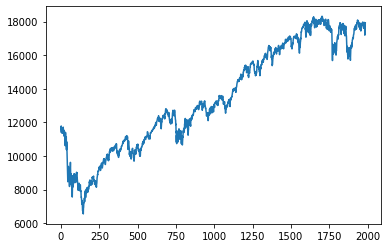

In [6]:
plt.plot(DJIA_test_plot["Time (Days)"], DJIA_test_plot["Open"], label='DJIA')

In [7]:
def to_dataset(your_set):
    DJIA_df = pd.read_csv("DJIA_w_topic.csv")
    #DJIA_df = DJIA_df.sort_values(by="Date", ascending=True)
    DJIA_df = DJIA_df.drop("Date", axis = 1)
    DJIA_df = DJIA_df.values

    DJIA_df_normaliser = preprocessing.MinMaxScaler()
    DJIA_df_normalised = DJIA_df_normaliser.fit_transform(DJIA_df)
    past_values_normalised =  np.array([DJIA_df_normalised[i:i + backwards_points].copy() for i in range(len(DJIA_df_normalised) - backwards_points)])
    next_day_values_normalised =  np.array([DJIA_df_normalised[:,0][i + backwards_points].copy() for i in range(len(DJIA_df_normalised) - backwards_points)])
    next_day_values_normalised = np.expand_dims(next_day_values_normalised, -1)
    next_day_values = np.array([DJIA_df[:,0][i + backwards_points].copy() for i in range(len(DJIA_df) - backwards_points)])
    next_day_values = np.expand_dims(next_day_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_values)
    
    assert past_values_normalised.shape[0] == next_day_values_normalised.shape[0]
    return past_values_normalised, next_day_values_normalised, next_day_values, y_normaliser

In [8]:
past_values, next_day_values, unscaled_y, y_normaliser = to_dataset("DJIA_w_topic.csv")

test_split = 0.8
n = int(past_values.shape[0] * test_split)

X_train = past_values[:n]
y_train = next_day_values[:n]

X_test = past_values[n:]
y_test = next_day_values[n:]

unscaled_y_test = unscaled_y[n:]

print(X_train.shape)
print(X_test.shape)

(1528, 75, 8)
(383, 75, 8)


In [10]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers

#https://keras.io/api/layers/recurrent_layers/lstm/

lstm_input = Input(shape = (backwards_points, 8), name='lstm_input')
x = LSTM(75, name = "lstm_0")(lstm_input)
x = Dropout(0.21, name = "lstm_dropout_0")(x)
x = Dense(64, name = "dense_0")(x)
x = Activation("sigmoid", name = "sigmoid_0")(x)
x = Dense(1, name = "dense_1")(x)
output = Activation("linear", name = "linear_output")(x)

model = Model(inputs = lstm_input, outputs=output)
adam = optimizers.Adam(lr = 0.0005)
model.compile(optimizer = adam, loss="mse")
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(X_test, y_test)
print(evaluation)

Train on 1375 samples, validate on 153 samples
Epoch 1/50
1375/1375 [==============================] - 4s 3ms/step - loss: 0.0173 - val_loss: 0.0015
Epoch 2/50
1375/1375 [==============================] - 3s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/50
1375/1375 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 8.1478e-04
Epoch 4/50
1375/1375 [==============================] - 3s 2ms/step - loss: 9.6955e-04 - val_loss: 6.3549e-04
Epoch 5/50
1375/1375 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 6.0311e-04
Epoch 6/50
1375/1375 [==============================] - 3s 2ms/step - loss: 9.4611e-04 - val_loss: 3.8540e-04
Epoch 7/50
1375/1375 [==============================] - 3s 2ms/step - loss: 8.4480e-04 - val_loss: 6.7830e-04
Epoch 8/50
1375/1375 [==============================] - 3s 2ms/step - loss: 7.6586e-04 - val_loss: 0.0013
Epoch 9/50
1375/1375 [==============================] - 3s 2ms/step - loss: 7.1754e-04 - val_loss: 0.

In [11]:
y_test_predicted = model.predict(X_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(past_values)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

1535.3347372460285


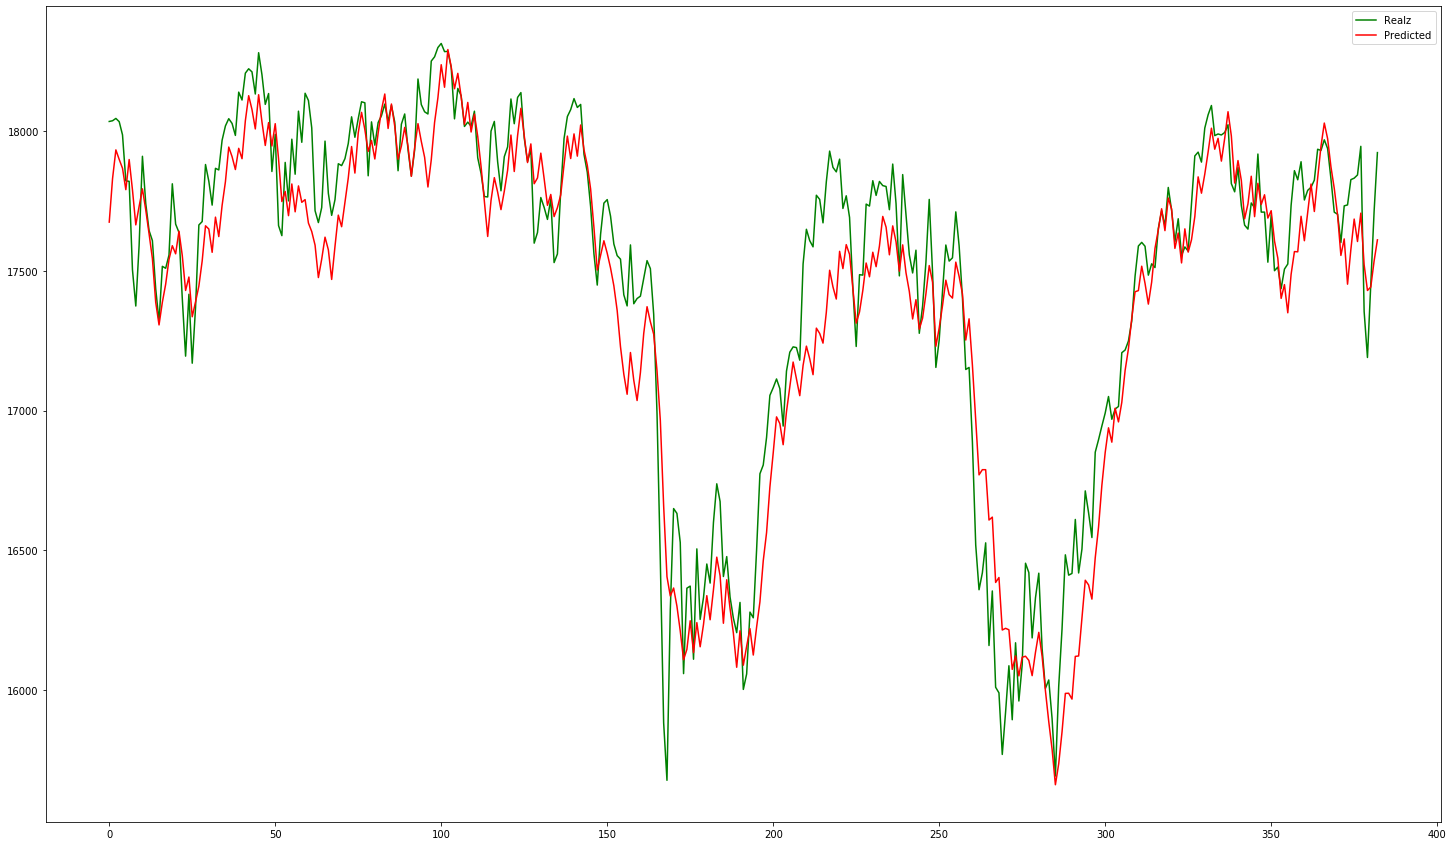

In [12]:
#get current figure
plt.gcf().set_size_inches(25, 15, forward=True)
plt.plot(unscaled_y_test, label="Real", color="green")
plt.plot(y_test_predicted, label="Prediction", color="red")
plt.legend(["Realz", "Predicted"])
plt.show()

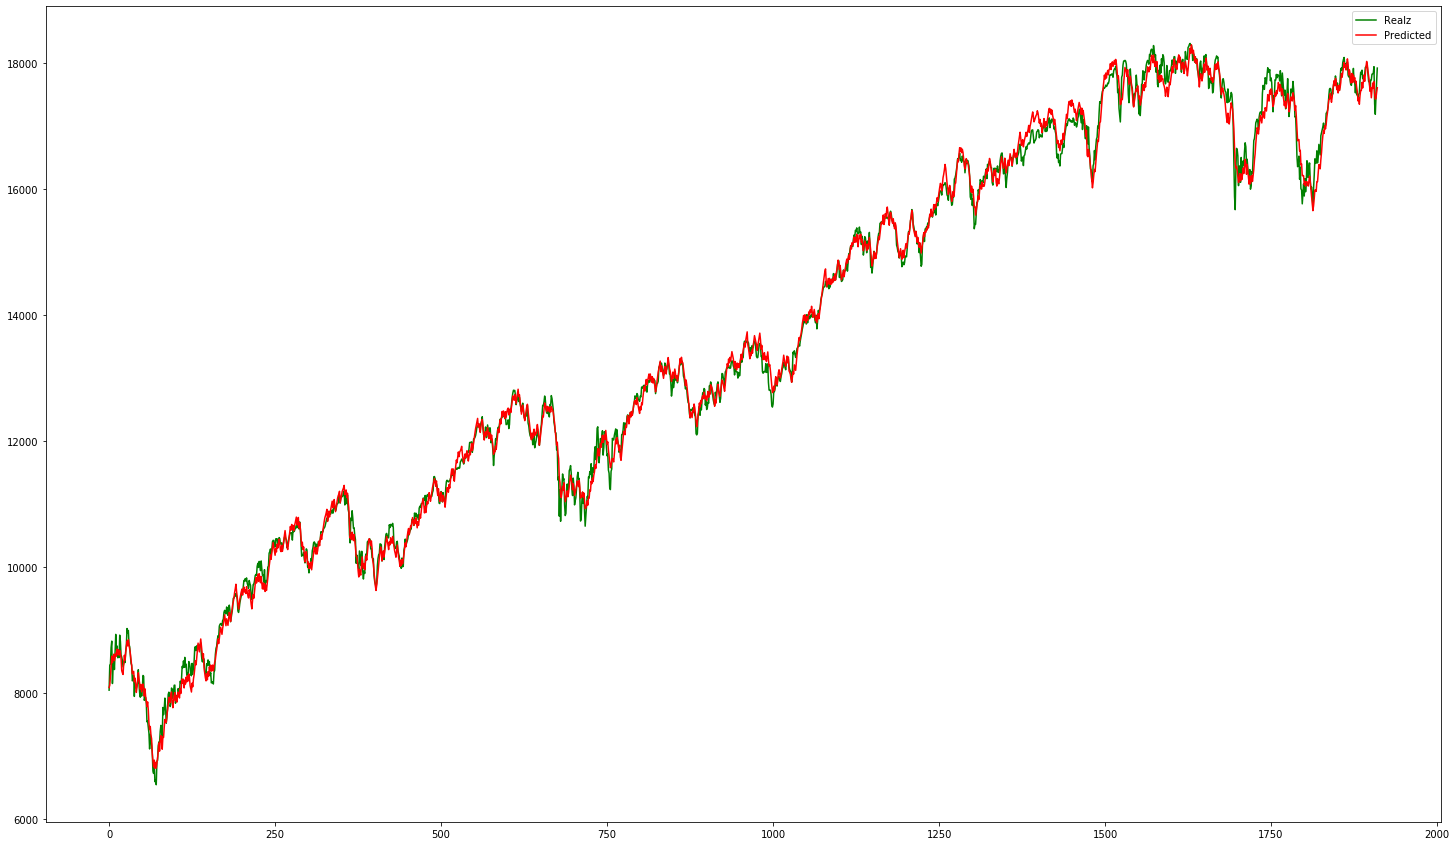

In [13]:
plt.gcf().set_size_inches(25, 15, forward=True)
plt.plot(unscaled_y, label="Real", color="green")
plt.plot(y_predicted, label="Prediction", color="red")
plt.legend(["Realz", "Predicted"])
plt.show()